In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from dative_chemprop.models.DativeCGR import DativeCGR

torch.set_float32_matmul_precision("high")
plt.rcParams["font.family"] = "Arial"
chemprop_dir = Path.cwd()
input_path = chemprop_dir / "data" / "ML_data_with_pesudo_state.csv"
result_path = chemprop_dir / "baseline_results"
if not result_path.exists():
    os.makedirs(result_path)
dataset = pd.read_csv(input_path, index_col=0).fillna("")
target_columns = ["ddG (kcal/mol)"]  # list of names of the columns containing targets
groups = dataset["reactants_couples_smiles"]
ys = dataset[target_columns].values

random_seed = 42
n_folds = 5

dataset

,rxn_smiles,ddG (kcal/mol),ee (%),acceptor_smiles,donor_smiles,donor_active_smiles,reactants_couples_smiles,reactants_active_couples_smiles,additives_smiles,solvents_smiles,...,dative_active_rxn_smiles,pure_rxn_smiles,pure_active_rxn_smiles,rxn_active_smiles,Ref.(DOI),temperature (C),pesudo_active_donor_rxn_smiles,donor_smiles_pesudo_active,no_extra_dative_rxn_smiles,no_extra_dative_pesudo_active_donor_rxn_smiles
0,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.279682,95,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F.CCOC...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F.CCOC...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.063894,93,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl.CCOC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl.CCOC(=...,CCN(CC)CC,ClCCl,...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
2,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,1.832202,90,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2.CCOC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2.CCOC(=...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
3,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.163032,94,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br.CCOC(=O)CC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br.CCOC(=O)C=C(...,CCN(CC)CC,ClCCl,...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
4,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.421718,96,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1.CCOC(=O)CC(=O)...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1.CCOC(=O)C=C([O...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,[O:8]=[C:7]1/[C:6](=[CH:5]/[c:23]2[cH:24][cH:2...,2.24328

In [2]:
cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
k_fold_spliting = []
for fold, (train_idx, test_idx) in enumerate(cv.split(dataset)):
    k_fold_spliting.append(
        pd.DataFrame(
            {
                "group": fold,
                "data_idx": dataset.index,
                "train or test": np.where(
                    dataset.index.isin(test_idx), "test", "train"
                ),
            }
        )
    )
    dataset_train = dataset.iloc[train_idx]
    dataset_test = dataset.iloc[test_idx]
    dataset_train.to_csv(chemprop_dir / "data" / "5-folds" / f"train_fold_{fold}.csv")
    dataset_test.to_csv(chemprop_dir / "data" / "5-folds" / f"test_fold_{fold}.csv")

In [3]:
from skfp.bases import BaseFingerprintTransformer
from skfp.fingerprints import (
    AtomPairFingerprint,
    AutocorrFingerprint,
    AvalonFingerprint,
    ECFPFingerprint,
    ERGFingerprint,
    EStateFingerprint,
    GhoseCrippenFingerprint,
    KlekotaRothFingerprint,
    LaggnerFingerprint,
    LayeredFingerprint,
    LingoFingerprint,
    MACCSFingerprint,
    MAPFingerprint,
    MHFPFingerprint,
    MQNsFingerprint,
    PatternFingerprint,
    PhysiochemicalPropertiesFingerprint,
    PubChemFingerprint,
    RDKitFingerprint,
    SECFPFingerprint,
    TopologicalTorsionFingerprint,
    VSAFingerprint,
)

random_seed = 42
fp_2d_generators = {
    "AtomPair": AtomPairFingerprint(n_jobs=-1),
    "Autocorr": AutocorrFingerprint(n_jobs=-1),
    "Avalon": AvalonFingerprint(n_jobs=-1),
    "ECFP": ECFPFingerprint(n_jobs=-1),
    "ERG": ERGFingerprint(n_jobs=-1),
    "EState": EStateFingerprint(n_jobs=-1),
    "GhoseCrippen": GhoseCrippenFingerprint(n_jobs=-1),
    "KlekotaRoth": KlekotaRothFingerprint(n_jobs=-1),
    "Laggner": LaggnerFingerprint(n_jobs=-1),
    "Layered": LayeredFingerprint(n_jobs=-1),
    "Lingo": LingoFingerprint(n_jobs=-1),
    "MACCS": MACCSFingerprint(n_jobs=-1),
    "MAP": MAPFingerprint(n_jobs=-1),
    "MHFP": MHFPFingerprint(n_jobs=-1),
    "MQNs": MQNsFingerprint(n_jobs=-1),
    "Pattern": PatternFingerprint(n_jobs=-1),
    "PhysiochemicalProperties": PhysiochemicalPropertiesFingerprint(n_jobs=-1),
    "PubChem": PubChemFingerprint(n_jobs=-1),
    "RDKit": RDKitFingerprint(n_jobs=-1),
    "SECFP": SECFPFingerprint(n_jobs=-1),
    "VSA": VSAFingerprint(n_jobs=-1),
    "TopologicalTorsion": TopologicalTorsionFingerprint(n_jobs=-1),
}

/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.base import RegressorMixin, is_regressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

classical_models = {
    "AdaBoost": AdaBoostRegressor(random_state=random_seed),
    "ExtraTrees": ExtraTreesRegressor(n_jobs=-1, random_state=random_seed),
    "GradientBoosting": GradientBoostingRegressor(random_state=random_seed),
    "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=random_seed),
    "DecisionTree": DecisionTreeRegressor(random_state=random_seed),
    "ExtraTree": ExtraTreeRegressor(random_state=random_seed),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=random_seed),
}

In [5]:
pd.DataFrame(
    {
        "model": [fpg.__class__.__name__ for fpg in fp_2d_generators.values()],
        "hyperparameters": [fpg.get_params() for fpg in fp_2d_generators.values()],
    }
)

,model,hyperparameters
0,AtomPairFingerprint,"{'batch_size': None, 'count': False, 'count_si..."
1,AutocorrFingerprint,"{'batch_size': None, 'n_jobs': -1, 'use_3D': F..."
2,AvalonFingerprint,"{'batch_size': None, 'count': False, 'fp_size'..."
3,ECFPFingerprint,"{'batch_size': None, 'count': False, 'count_si..."
4,ERGFingerprint,"{'batch_size': None, 'fuzz_increment': 0.3, 'm..."
5,EStateFingerprint,"{'batch_size': None, 'n_jobs': -1, 'sparse': F..."
6,GhoseCrippenFingerprint,"{'batch_size': None, 'count': False, 'n_jobs':..."
7,KlekotaRothFingerprint,"{'batch_size': None, 'count': False, 'n_jobs':..."
8,LaggnerFingerprint,"{'batch_size': None, 'count': False, 'n_jobs':..."
9,LayeredFingerprint,"{'batch_size': None, 'fp_size': 2048, 'linear_..."


In [6]:
from tempfile import mkdtemp
from typing import Sequence, Tuple

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import BaseCrossValidator, KFold, LeaveOneGroupOut
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.preprocessing import RobustScaler

cachedir = mkdtemp()


def build_descriptor(
    fpgen: BaseFingerprintTransformer | Sequence[BaseFingerprintTransformer],
) -> ColumnTransformer:
    if isinstance(fpgen, Sequence):
        fp_gen_pipeline = make_pipeline(
            make_union(*fpgen),
            SimpleImputer(strategy="most_frequent", keep_empty_features=True),
            RobustScaler(),
            memory=cachedir,
        )
    elif isinstance(fpgen, BaseFingerprintTransformer):
        fp_gen_pipeline = make_pipeline(
            fpgen,
            SimpleImputer(strategy="most_frequent", keep_empty_features=True),
            RobustScaler(),
            memory=cachedir,
        )
    else:
        raise ValueError(
            "fpgen must be a BaseFingerprintTransformer or a sequence of BaseFingerprintTransformer"
        )
    preprocessor = ColumnTransformer(
        transformers=[
            (subcol, fp_gen_pipeline, subcol)
            for subcol in (
                "acceptor_smiles",
                "donor_smiles",
                "additives_smiles",
                "solvents_smiles",
                "catalysts_pre_smiles",
                "ligands_smiles",
                "products_smiles",
            )
        ]
    )
    preprocessor.set_output(transform="pandas")
    return preprocessor


def build_reg_model(
    fpgen: BaseFingerprintTransformer | Sequence[BaseFingerprintTransformer],
    model: RegressorMixin,
) -> Pipeline:
    preprocessor = build_descriptor(fpgen)
    return make_pipeline(preprocessor, model)


build_reg_model(
    PubChemFingerprint(n_jobs=-1),
    RandomForestRegressor(n_jobs=-1, random_state=random_seed),
)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('acceptor_smiles',
                                                  Pipeline(memory='/tmp/tmpoztoj2u9',
                                                           steps=[('pubchemfingerprint',
                                                                   PubChemFingerprint(n_jobs=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(keep_empty_features=True,
                                                                                 strategy='most_frequent')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  'acceptor_smiles'),
                                                 ('donor_smiles',
                                                  Pipeline(memory...
                                                                   RobustScaler())]),
                                                  'ligands_smiles'),
                                                 ('products_smiles',
                                                  Pipeline(memory='/tmp/tmpoztoj2u9',
                                                           steps=[('pubchemfingerprint',
                                                                   PubChemFingerprint(n_jobs=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(keep_empty_features=True,
                                                                                 strategy='most_frequent')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  'products_smiles')])),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [7]:
X = dataset.drop("ddG (kcal/mol)", axis=1)
y = dataset["ddG (kcal/mol)"]

result_list = []
for fp_gen_name, fp_gen in fp_2d_generators.items():
    if not all(
        (result_path / f"{fp_gen_name}_with_{model_name}_ddG.csv").exists()
        for model_name in classical_models
    ):
        preprocessor = build_descriptor(fp_gen)
        desc = preprocessor.fit_transform(X)
    for model_name, model in classical_models.items():
        name = f"{fp_gen_name}_with_{model_name}_ddG"
        if (result_path / f"{name}.csv").exists():
            temp_df = pd.read_csv(result_path / f"{name}.csv", index_col=0)
            result_list.append(temp_df)
            temp_results = []
            for label, subdf in temp_df.groupby("idx"):
                truthes = subdf["y_true"]
                preds = subdf["y_pred"]
                temp_results.append(
                    {
                        "r2 score": r2_score(truthes, preds),
                        "mae": mean_absolute_error(truthes, preds),
                        "rmse": root_mean_squared_error(truthes, preds),
                        "pearson r": pearsonr(truthes, preds)[0],
                    }
                )
            temp_results = pd.DataFrame(temp_results)
            result_list.append(temp_df)
            print(
                f"{name:80}, R2 score: {temp_results['r2 score'].mean():15.4f}, "
                f"MAE: {temp_results['mae'].mean():15.4f}, "
                f"RMSE: {temp_results['rmse'].mean():15.4f} "
                f"Pearson R: {temp_results['pearson r'].mean():15.4f}"
            )
            continue
        result_dfs = []
        for idx, spliting in enumerate(k_fold_spliting):
            m = classical_models[model_name]
            train_index = spliting.loc[spliting["train or test"] == "train"].index
            test_index = spliting.loc[spliting["train or test"] == "test"].index
            model.fit(desc.iloc[train_index], y.iloc[train_index])
            y_pred = m.predict(desc.iloc[test_index])
            result_dfs.append(
                pd.DataFrame(
                    {
                        "idx": [idx] * len(test_index),
                        "data_idx": test_index,
                        "y_true": y.iloc[test_index],
                        "y_pred": y_pred,
                        "method": [f"{fp_gen_name}_{model_name}"] * len(test_index),
                    }
                )
            )
        d = pd.concat(result_dfs)
        d.to_csv(result_path / f"{name}.csv")
        result_list.append(d)
        temp_results = []
        for label, subdf in d.groupby("idx"):
            truthes = subdf["y_true"]
            preds = subdf["y_pred"]
            temp_results.append(
                {
                    "r2 score": r2_score(truthes, preds),
                    "mae": mean_absolute_error(truthes, preds),
                    "rmse": root_mean_squared_error(truthes, preds),
                    "pearson r": pearsonr(truthes, preds)[0],
                }
            )
        temp_results = pd.DataFrame(temp_results)
        print(
            f"{name:80}, R2 score: {temp_results['r2 score'].mean():15.4f}, "
            f"MAE: {temp_results['mae'].mean():15.4f}, "
            f"RMSE: {temp_results['rmse'].mean():15.4f} "
            f"Pearson R: {temp_results['pearson r'].mean():15.4f}"
        )

AtomPair_with_AdaBoost_ddG                                                      , R2 score:          0.4302, MAE:          0.5526, RMSE:          0.6619 Pearson R:          0.7139
AtomPair_with_ExtraTrees_ddG                                                    , R2 score:          0.5726, MAE:          0.3898, RMSE:          0.5739 Pearson R:          0.7799
AtomPair_with_GradientBoosting_ddG                                              , R2 score:          0.6506, MAE:          0.4001, RMSE:          0.5178 Pearson R:          0.8106
AtomPair_with_RandomForest_ddG                                                  , R2 score:          0.7012, MAE:          0.3393, RMSE:          0.4781 Pearson R:          0.8384
AtomPair_with_DecisionTree_ddG                                                  , R2 score:          0.5267, MAE:          0.4114, RMSE:          0.6038 Pearson R:          0.7624
AtomPair_with_ExtraTree_ddG                                                     , R2 score:         

In [8]:
result_list[0]

,idx,data_idx,y_true,y_pred,method
15,0,15,0.949466,1.056415,AtomPair_AdaBoost
23,0,23,1.380211,1.262040,AtomPair_AdaBoost
29,0,29,2.768043,2.476410,AtomPair_AdaBoost
30,0,30,3.188620,2.522608,AtomPair_AdaBoost
32,0,32,1.658203,1.316531,AtomPair_AdaBoost
...,...,...,...,...,...
1629,4,1629,1.352589,1.051214,AtomPair_AdaBoost
1634,4,1634,0.255987,1.051214,AtomPair_AdaBoost
1638,4,1638,0.168779,1.051214,AtomPair_AdaBoost
1647,4,1647,2.243283,1.138674,AtomPair_AdaBoost


In [9]:
metrics_results = []
for method, subdf in pd.concat(result_list).groupby("method"):
    temp_r2s = []
    temp_maes = []
    temp_pearsonrs = []
    for idx, subsubdf in subdf.groupby("idx"):
        temp_r2s.append(r2_score(subsubdf["y_true"], subsubdf["y_pred"]))
        temp_maes.append(mean_absolute_error(subsubdf["y_true"], subsubdf["y_pred"]))
        temp_pearsonrs.append(pearsonr(subsubdf["y_true"], subsubdf["y_pred"])[0])
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "R$^2$",
            "value": np.mean(temp_r2s),
        }
    )
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "MAE (kcal/mol)",
            "value": np.mean(temp_maes),
        }
    )
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "pearsonr",
            "value": np.mean(temp_pearsonrs),
        }
    )

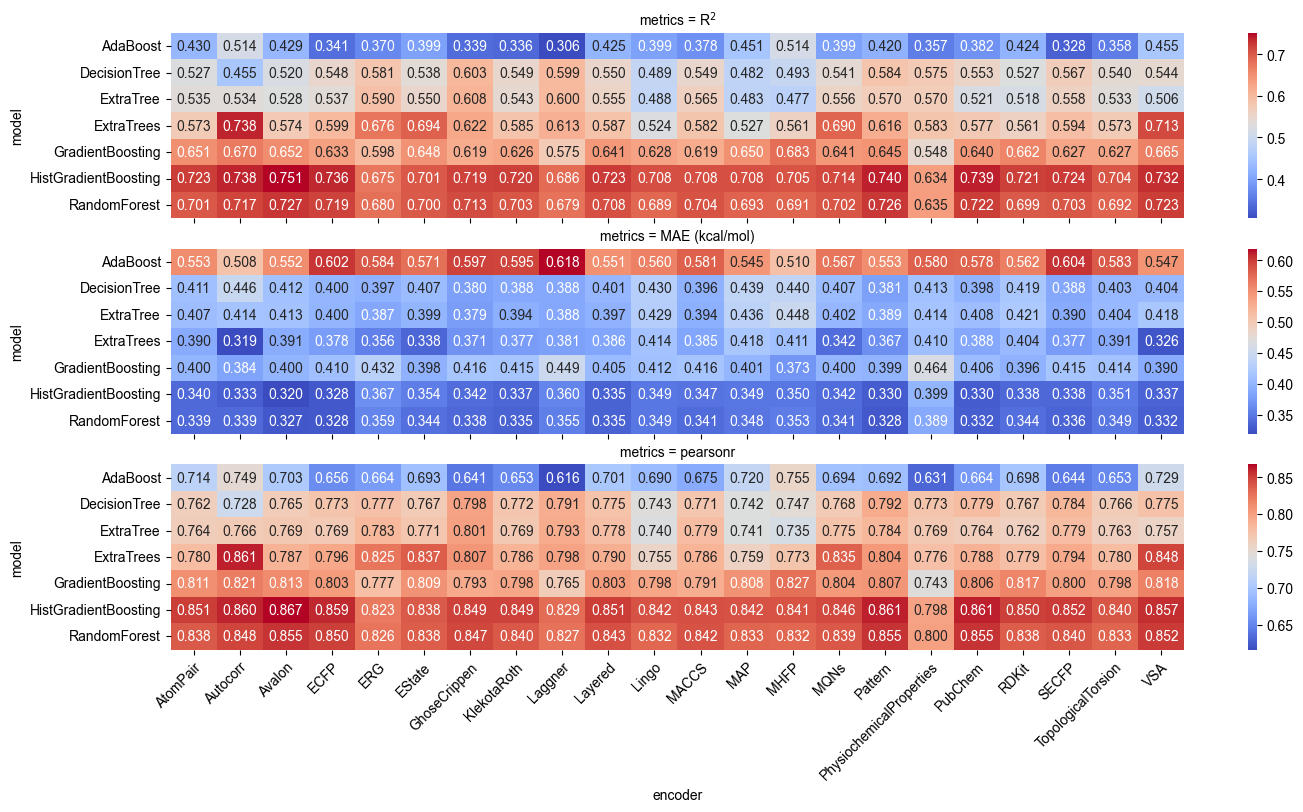

In [10]:
import seaborn as sns

g = sns.FacetGrid(
    data=pd.DataFrame(metrics_results),
    row="metrics",
    sharex=True,
)
for (i, j, k), data_ijk in g.facet_data():
    ax = g.facet_axis(i, j, k)
    sns.heatmap(
        data=data_ijk.pivot(index="model", columns="encoder", values="value"),
        annot=True,
        xticklabels=True,
        fmt=".3f",
        ax=ax,
        cmap="coolwarm",
    )
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
        label.set_rotation_mode("anchor")
g.figure.tight_layout()
g.figure.set_size_inches(40, 8)

In [ ]:
rxn_smiles_columns = [
    "rxn_smiles",
]  # use different reaction SMILES to do data augmentation
target_columns = ["ddG (kcal/mol)"]  # list of names of the columns containing targets
batch_size = 128
name = "CGRNN"

idxs = []
truthes = []
preds = []
data_splits = [
    (
        pd.read_csv(
            chemprop_dir / "data" / "5-folds" / f"train_fold_{i}.csv", index_col=0
        ),
        pd.read_csv(
            chemprop_dir / "data" / "5-folds" / f"test_fold_{i}.csv", index_col=0
        ),
    )
    for i in range(n_folds)
]
result_dfs = []
for idx, (train_data, test_data) in enumerate(data_splits):
    train_smis = train_data[rxn_smiles_columns].values
    train_y = train_data[target_columns].values
    test_smis = test_data[rxn_smiles_columns].values
    test_y = test_data[target_columns].values
    model = DativeCGR(
        model_name=f"1-naive_cv_{idx}",
        seed=random_seed,
    )
    if not os.path.exists(model.model_path):
        model.fit(
            train_smis.flatten(),
            train_y.repeat(len(rxn_smiles_columns), axis=0),
            batch_size=batch_size,
            max_epochs=600,
            val_smis=test_smis.flatten(),
            val_y=test_y.repeat(len(rxn_smiles_columns), axis=0),
        )
    pred = model.predict(test_smis.flatten(), devices=[0])[:, 0]
    ddg_pred = pred.reshape(-1, len(rxn_smiles_columns)).mean(axis=1).flatten()
    ddg_true = test_y[:, 0].flatten()
    result_dfs.append(
        pd.DataFrame(
            {
                "idx": [idx] * len(test_data.index),
                "data_idx": test_data.index,
                "y_true": ddg_true,
                "y_pred": ddg_pred,
                "method": [name] * len(test_data.index),
            }
        )
    )
d = pd.concat(result_dfs)
result_list.append(d)

Loaded model from .checkpoints/rxn_smiles_0527_cv_0_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 28.71it/s]
Loaded model from .checkpoints/rxn_smiles_0527_cv_1_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 93.10it/s]
Loaded model from .checkpoints/rxn_smiles_0527_cv_2_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 94.19it/s] 
Loaded model from .checkpoints/rxn_smiles_0527_cv_3_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 109.94it/s]
Loaded model from .checkpoints/rxn_smiles_0527_cv_4_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 77.05it/s]


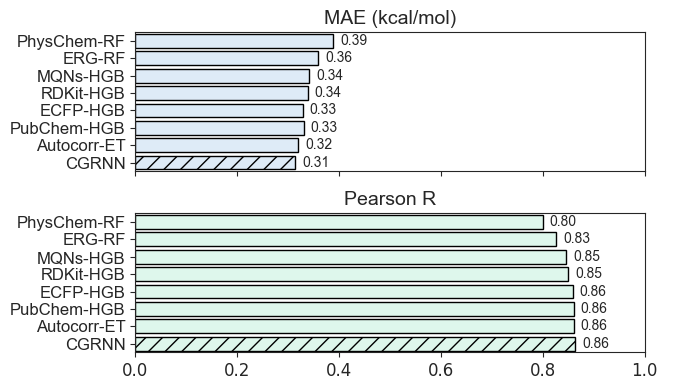

In [12]:
import seaborn as sns

selected_methods = {
    "PhysiochemicalProperties_RandomForest": "PhysChem-RF",
    "ERG_RandomForest": "ERG-RF",
    "MQNs_HistGradientBoosting": "MQNs-HGB",
    "RDKit_HistGradientBoosting": "RDKit-HGB",
    "ECFP_HistGradientBoosting": "ECFP-HGB",
    "PubChem_HistGradientBoosting": "PubChem-HGB",
    "Autocorr_ExtraTrees": "Autocorr-ET",
    "CGRNN": "CGRNN",
}
results = []
for method in selected_methods:
    for df in result_list:
        if df["method"].iloc[0] != method:
            continue
        for label, subdf in df.groupby("idx"):
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "MAE",
                    "value": mean_absolute_error(subdf["y_true"], subdf["y_pred"]),
                }
            )
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "Pearson R",
                    "value": pearsonr(subdf["y_true"], subdf["y_pred"])[0],
                }
            )
with sns.axes_style("ticks"):
    g = sns.catplot(
        pd.DataFrame(results),
        y="method",
        x="value",
        row="metrics",
        kind="bar",
        sharex=True,
        errorbar=None,
        facet_kws=dict(despine=False, xlim=(0, 1)),
    )
    g.set_xlabels("")
    g.set_ylabels("")
    g.set_yticklabels(selected_methods.values(), fontfamily="Arial", fontsize=12)
    g.figure.set_size_inches(7, 4)
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        if idx == 0:
            for bar in ax.containers[0]:
                bar.set_edgecolor("black")
                bar.set_facecolor(color="#DEEBF7")
            else:
                bar.set_hatch("//")
            ax.set_title("MAE (kcal/mol)", fontsize=14, fontfamily="Arial")
        if idx == 1:
            for bar in ax.containers[0]:
                bar.set_edgecolor("black")
                bar.set_facecolor(color="#DEF7EC")
            else:
                bar.set_hatch("//")
            ax.set_title("Pearson R", fontsize=14, fontfamily="Arial")
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_fontsize(12)
        ax.bar_label(
            container=ax.containers[0],
            fmt="%.2f",
            padding=5,
            fontfamily="Arial",
            fontsize=10,
        )

g.tight_layout()
g.figure.savefig("img/5-fold-Validation.png", dpi=300)

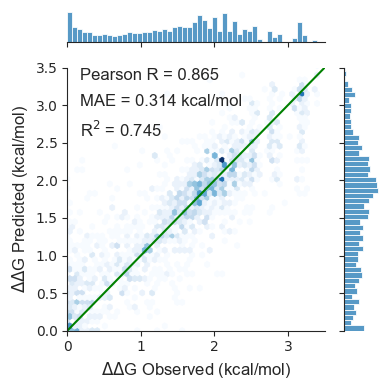

In [13]:
with sns.axes_style("ticks"):
    g = sns.JointGrid(data=d, x="y_true", y="y_pred")
    g.ax_joint.hexbin(
        x=d["y_true"],
        y=d["y_pred"],
        gridsize=50,
        cmap="Blues",
        linewidths=0.5,
        mincnt=1,
    )
    sns.histplot(
        data=d,
        bins=50,
        x="y_true",
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=d,
        bins=50,
        y="y_pred",
        legend=False,
        ax=g.ax_marg_y,
    )
    g.ax_joint.text(
        0.05,
        1,
        f"Pearson R = {pearsonr(d['y_true'], d['y_pred'])[0]:5.3f}",
        transform=g.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
        fontfamily="Arial",
    )
    g.ax_joint.text(
        0.05,
        0.9,
        f"MAE = {mean_absolute_error(d['y_true'], d['y_pred']):5.3f} kcal/mol",
        transform=g.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
        fontfamily="Arial",
    )
    g.ax_joint.text(
        0.05,
        0.8,
        f"R$^2$ = {r2_score(d['y_true'], d['y_pred']):5.3f}",
        transform=g.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
        fontfamily="Arial",
    )

    g.ax_joint.set_xlim(0, 3.5)
    g.ax_joint.set_ylim(0, 3.5)
    g.ax_joint.set_xlabel(
        "$\Delta\Delta$G Observed (kcal/mol)",
        fontdict={"size": 12, "fontfamily": "Arial"},
    )
    g.ax_joint.set_ylabel(
        "$\Delta\Delta$G Predicted (kcal/mol)",
        fontdict={"size": 12, "fontfamily": "Arial"},
    )
    g.ax_joint.plot([0, 3.5], [0, 3.5], color="green", linestyle="-")
g.figure.tight_layout()
g.figure.set_size_inches(4, 4)
plt.tight_layout()
g.figure.savefig("img/5-Fold-Validation.png", dpi=300)